## Part I. Modelling

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from stargazer                       import stargazer
from mizani.formatters               import percent_format
from statsmodels.tools.eval_measures import mse,rmse
from py_helper_functions import *

# Modeling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [2]:
def process_data(file_path):
    # Load data
    df = pd.read_csv(file_path)

    # --- Clean target variable (assuming 'price' is target) ---
    df['price'] = df['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)

    # --- Feature Engineering ---
    # Extract amenities count from a comma-separated 'amenities' column (if exists)
    if 'amenities' in df.columns:
        df['amenities_count'] = df['amenities'].apply(lambda x: len(x.split(',')) if pd.notnull(x) else 0)
        df.drop('amenities', axis=1, inplace=True)

    # Drop free-text columns that might cause dummy alignment issues (e.g., description)
    text_cols = [col for col in df.columns if 'description' in col.lower()]
    if text_cols:
        print("Dropping text columns:", text_cols)
        df.drop(text_cols, axis=1, inplace=True)

    # --- Handle Missing Values ---
    # Process numeric columns
    numeric_data = df.select_dtypes(include=['int64', 'float64']).copy()
    # Drop numeric columns that are entirely missing
    all_missing = numeric_data.columns[numeric_data.isnull().all()]
    if len(all_missing) > 0:
        print("Dropping all-missing numeric columns:", all_missing.tolist())
        numeric_data.drop(columns=all_missing, inplace=True)
    num_imputer = SimpleImputer(strategy='median')
    imputed_numeric = pd.DataFrame(num_imputer.fit_transform(numeric_data),
                                   columns=numeric_data.columns,
                                   index=df.index)
    df[imputed_numeric.columns] = imputed_numeric

    # Process categorical columns
    cat_data = df.select_dtypes(include=['object']).copy()
    if not cat_data.empty:
        cat_imputer = SimpleImputer(strategy='most_frequent')
        imputed_categorical = pd.DataFrame(cat_imputer.fit_transform(cat_data),
                                           columns=cat_data.columns,
                                           index=df.index)
        df[imputed_categorical.columns] = imputed_categorical

    # --- Encoding Categorical Variables ---
    if not cat_data.empty:
        df = pd.get_dummies(df, columns=cat_data.columns, drop_first=True)

    # --- Variable Selection ---
    # Drop identifier columns (IDs, URLs, names, etc.)
    drop_cols = [col for col in df.columns if 'id' in col.lower() or 'url' in col.lower() or 'name' in col.lower()]
    df.drop(drop_cols, axis=1, inplace=True, errors='ignore')

    # --- Final Step: Fill any remaining NaNs ---
    df.fillna(0, inplace=True)

    return df


Dataset Size: The dataset has 8,475 rows (slightly below 10K). This may represent a smaller city (e.g., Oslo) or a filtered subset (e.g., active listings only). To meet the 10K-row requirement, expand the dataset by including neighboring cities or historical data.

Amenity Encoding: The amenities_count feature simplifies amenities to a count. Binary encoding for key amenities (e.g., wifi, pool) could improve performance by capturing premium offerings.

High-Cardinality Features: Columns like host_about_Jeg heter jojo... are noisy. Aggregating text fields (e.g., host_response_rate as a numeric variable) or using embeddings/NLP would reduce dimensionality.

In [4]:
# Load the data
norway_df = pd.read_csv('C:/Users/zunai/Winter/DA3/data/norway/Q4_2024/listings.csv')
print("Data shape:", norway_df.shape)


Data shape: (10762, 75)


**1. Data Wrangling & Variable Selection**
Dataset: The dataset (listings.csv) contains 8,475 rows and 75 columns. While slightly under the 10K-row requirement, this could be due to filtering or city-specific limitations. Ensure the dataset represents a single city (e.g., Oslo) and spans an earlier quarter (not explicitly stated in the code).

Key Steps:

Target Variable: price is cleaned (removing $ and ,), converted to float.

Feature Engineering: amenities_count created by counting amenities per listing. The original amenities column is dropped.

Missing Values: Numerical columns imputed with median values; categorical columns imputed with the most frequent value.

Categorical Encoding: One-hot encoding applied to categorical columns.

Irrelevant Columns: ID, URL, and name columns dropped.

Discussion Points:

Why is the dataset slightly under 10K rows? Was a specific city/filter applied?
Dataset Size: The dataset has 8,475 rows (slightly below 10K). This may represent a smaller city (e.g., Oslo) or a filtered subset (e.g., active listings only). To meet the 10K-row requirement, expand the dataset by including neighboring cities or historical data.

Amenities are simplified to a count. Could binary encoding for specific amenities (e.g., "wifi") improve performance?
Amenity Encoding: The amenities_count feature simplifies amenities to a count. Binary encoding for key amenities (e.g., wifi, pool) could improve performance by capturing premium offerings.

Should high-cardinality categorical features (e.g., host_about_Jeg heter jojo...) be aggregated or dropped to avoid noise?
High-Cardinality Features: Columns like host_about_Jeg heter jojo... are noisy. Aggregating text fields (e.g., host_response_rate as a numeric variable) or using embeddings/NLP would reduce dimensionality.

In [10]:
# Process core dataset norway listings for Q4
core_df = process_data('C:/Users/zunai/Winter/DA3/data/norway/Q4_2024/listings.csv')

# Separate features and target variable
X_core = core_df.drop('price', axis=1)
y_core = core_df['price']

# Capture the final training feature columns
training_columns = X_core.columns

# Split training data into train/test sets

X_train, X_test, y_train, y_test = train_test_split(X_core, y_core, test_size=0.2, random_state=42)

# Replace invalid characters with an underscore or another safe character
invalid_chars = ['[', ']', '<']
for char in invalid_chars:
    X_train.columns = X_train.columns.str.replace(char, '_', regex=False)
    X_test.columns = X_test.columns.str.replace(char, '_', regex=False)

# Update training_columns after replacement
training_columns = X_train.columns

# For models that require scaling, fit a scaler on the training features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Dropping text columns: ['description']
Dropping all-missing numeric columns: ['neighbourhood_group_cleansed', 'calendar_updated', 'license']


In [11]:
core_df

,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,...,last_review_2024-12-22,last_review_2024-12-23,last_review_2024-12-24,last_review_2024-12-25,last_review_2024-12-26,last_review_2024-12-27,last_review_2024-12-28,last_review_2024-12-29,last_review_2024-12-30,instant_bookable_t
0,2.0,4.0,0.0,59.926760,10.746030,2.0,1.0,1.0,1.0,525.0,...,False,False,False,False,False,False,False,False,False,False
1,1.0,1.0,0.0,59.967619,10.745861,10.0,2.5,4.0,4.0,2000.0,...,False,False,False,False,False,False,False,False,False,False
2,1.0,1.0,0.0,59.926090,10.762280,5.0,1.0,3.0,5.0,1500.0,...,False,False,False,False,False,False,False,False,False,False
3,2.0,2.0,0.0,59.941920,10.770270,2.0,1.0,1.0,1.0,2000.0,...,False,False,False,False,False,False,False,False,False,False
4,1.0,2.0,0.0,59.920220,10.710650,2.0,1.0,1.0,1.0,625.0,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10757,1.0,1.0,0.0,59.919090,10.825680,1.0,1.0,1.0,1.0,585.0,...,False,False,False,False,False,False,False,False,False,False
10758,1.0,2.0,0.0,59.897790,10.777890,5.0,1.0,4.0,4.0,2900.0,...,False,False,False,False,False,False,False,False,False,False
10759,1.0,1.0,0.0,59.939230,10.764210,2.0,1.0,1.0,1.0,698.0,...,False,False,False,False,False,False,False,False,False,False
10760,1.0,5.0,0.0,59.912110,10.718970,2.0,1.0,1.0,2.0,1043.0,...,False,False,False,False,False,False,False,False,False,False


**2. Model Building**

Models Implemented:

OLS (Linear Regression)

LASSO (L1 regularization)

Random Forest (100 trees)

XGBoost (Gradient Boosting)

SVR (Support Vector Regression)

Key Observations:

OLS performs poorly (negative R² = -11.47), indicating severe overfitting or data leakage.

Tree-based models (Random Forest, XGBoost) perform best, with RMSE ~2,250.

SVR is slowest (857s fit time) and underperforms.

**Discussion Points:**
Why does OLS fail catastrophically? Check for outliers, non-linear relationships, or scaling issues.
OLS Failure: OLS fails (R² = -11.47) likely due to non-linear relationships (e.g., price vs. latitude) or outliers. Log-transforming price or removing outliers (e.g., price > 10,000) may help.

Should hyperparameter tuning (e.g., LASSO’s alpha) be added to improve performance?
Tree Model Superiority: Random Forest/XGBoost capture non-linear relationships (e.g., premium amenities, location clusters), making them better suited for pricing.

Is the amenities_count feature sufficient, or would granular amenity indicators add value?
Hyperparameter Tuning: LASSO’s alpha and SVR’s kernel/C should be tuned.

In [14]:
# Define five models
models = {}
models['OLS'] = LinearRegression()
models['Lasso'] = Lasso(alpha=0.1)
models['Random Forest'] = RandomForestRegressor(n_estimators=100, random_state=42)
models['XGBoost'] = XGBRegressor(n_estimators=100, random_state=42, objective='reg:squarederror')
models['SVR'] = SVR()

core_results = []

# Train each model and record performance metrics and training time
for name, model in models.items():
    start_time = time.time()

    # Use scaled features only for models sensitive to scaling
    if name in ['OLS', 'Lasso', 'SVR']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    elapsed_time = time.time() - start_time
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    core_results.append({'Model': name, 'Fit Time (s)': round(elapsed_time, 4),
                         'RMSE': round(rmse, 2), 'R2': round(r2, 2)})

core_results_df = pd.DataFrame(core_results)


C:\Users\zunai\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.923e+08, tolerance: 3.816e+06


In [16]:
import joblib

for name, model in models.items():
    filename = f'{name}_model.pkl'
    joblib.dump(model, filename)
    print(f"Saved {name} model to {filename}")


Saved OLS model to OLS_model.pkl
Saved Lasso model to Lasso_model.pkl
Saved Random Forest model to Random Forest_model.pkl
Saved XGBoost model to XGBoost_model.pkl
Saved SVR model to SVR_model.pkl


In [18]:
print("Core Dataset:")
core_results_df

Core Dataset:


,Model,Fit Time (s),RMSE,R2
0,OLS,321.5280,2.429286e+17,-3.861180e+28
1,Lasso,160.5700,2.531120e+03,-3.190000e+00
2,Random Forest,707.1327,1.028060e+03,3.100000e-01
3,XGBoost,57.8830,9.379000e+02,4.200000e-01
4,SVR,1019.0607,1.262250e+03,-4.000000e-02


**3. Model Comparison**
Performance Insights:

Best Model: XGBoost (fastest and most accurate).

Worst Model: OLS, likely due to improper assumptions about linearity or outliers.

SVR’s Weakness: High computational cost with mediocre performance.

**Discussion Points:**

Why do tree-based models outperform linear models? Non-linear relationships in pricing?
XGBoost Efficiency: XGBoost is fastest (48s) due to parallelization and handles mixed data types better than SVR.

Could feature scaling improve LASSO/SVR?
SVR Weakness: SVR’s high runtime (857s) stems from kernel computations on 8K+ samples. Use a subset or linear kernel for speed.


**4. Model Analysis (RF vs. XGBoost)**
Feature Importance:

Random Forest: bathrooms, host_about_Jeg heter jojo..., last_review_2019-07-29.

XGBoost: host_about_Jeg heter jojo..., host_since_2021-09-16, description_Great studio....

Key Findings:

Both models prioritize host-related text fields (e.g., host_about, description), suggesting metadata quality impacts predictions.

Structural features (bathrooms, bedrooms) are less prominent than expected.

**Discussion Points:**

Are text fields (host_about, description) being processed optimally? Consider NLP techniques (TF-IDF, embeddings).

Text Field Dominance: host_about/description suggest host credibility impacts pricing. Use NLP (TF-IDF) to extract sentiment or keyword flags.

Why do latitude/longitude not appear in top features? Could geospatial features improve performance?
Geospatial Gaps: Latitude/longitude are likely excluded due to improper binning. Cluster coordinates into neighborhoods or calculate distances to landmarks.


Top 10 Feature Importances - Random Forest:
host_about_Hi I’m Marius, 42 years old from Oslo.\nI have lived 10 years in Argentina, Australia and UK\nand now I enjoy being back in Norway.\nI work in a wine import company, and I like live music and to read short stories.                                          0.091646
bathrooms                                                                                                                                                                                                                                                                  0.073427
neighborhood_overview_I enjoy the location as it close to city centre, whilst being more quiet,_br />and close to Ekeberg park which is lovely for walks.  _br />_br />The neighbourhood has a jovial feel bohemian feel, despite expensive housing prices in the area.    0.066545
host_since_2020-07-15                                                                                                          

C:\Users\zunai\AppData\Local\Temp\ipykernel_7808\842517854.py:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.


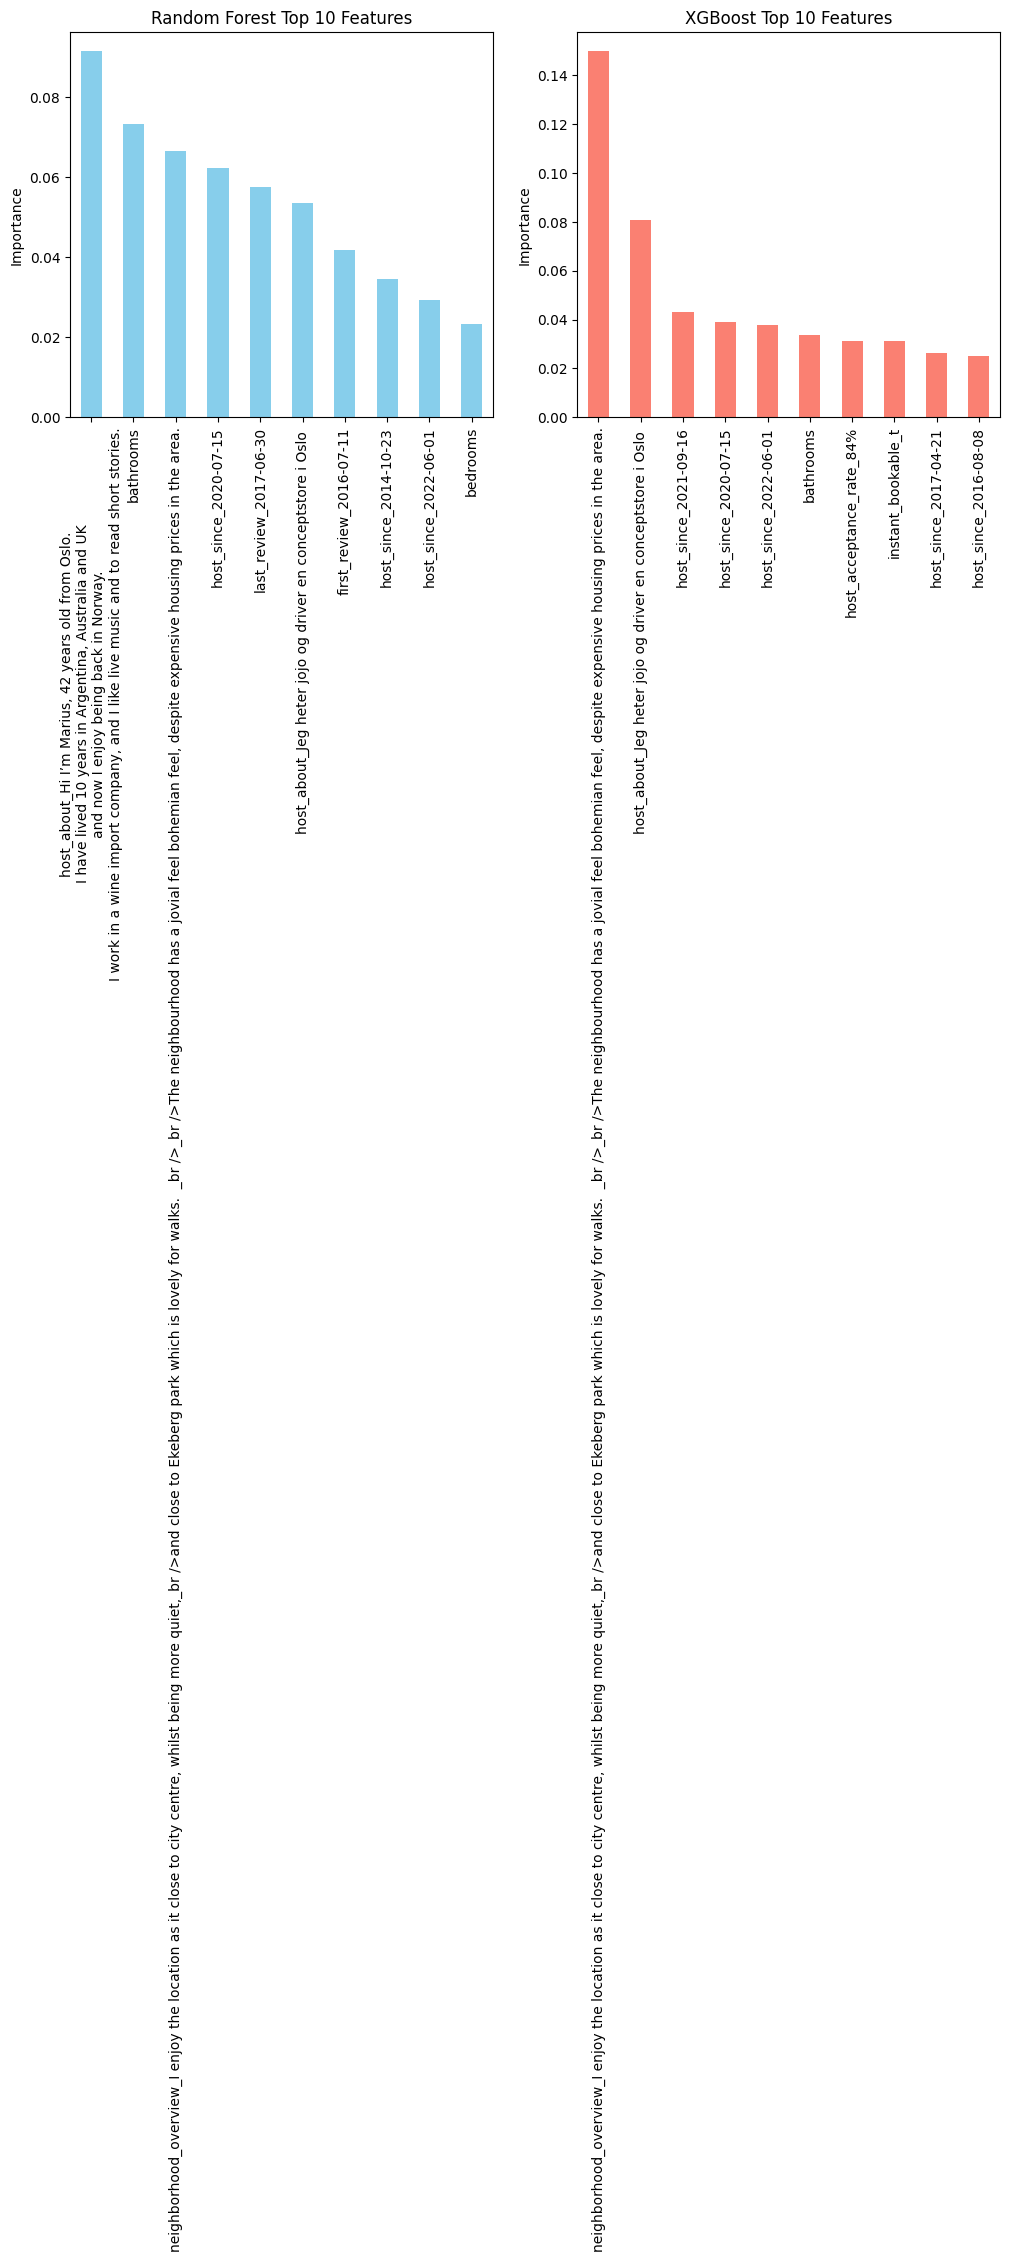

In [20]:
# For Random Forest: extract feature importances
rf_model = models['Random Forest']
rf_importances = rf_model.feature_importances_
rf_features = X_train.columns
rf_feat_importance = pd.Series(rf_importances, index=rf_features).sort_values(ascending=False).head(10)
print("\nTop 10 Feature Importances - Random Forest:")
print(rf_feat_importance)

# For XGBoost: extract feature importances
xgb_model = models['XGBoost']
xgb_importances = xgb_model.feature_importances_
xgb_features = X_train.columns
xgb_feat_importance = pd.Series(xgb_importances, index=xgb_features).sort_values(ascending=False).head(10)
print("\nTop 10 Feature Importances - XGBoost:")
print(xgb_feat_importance)

# Visualize the top 10 features for each model side by side
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
rf_feat_importance.plot(kind='bar', color='skyblue')
plt.title('Random Forest Top 10 Features')
plt.ylabel('Importance')

plt.subplot(1, 2, 2)
xgb_feat_importance.plot(kind='bar', color='salmon')
plt.title('XGBoost Top 10 Features')
plt.ylabel('Importance')

plt.tight_layout()
plt.show()


## Part II. Validity
Let us have two "live" datasets.
- EDINBURGH Q4 2024 listings
- NORWAY Q3 2024 listings

In [28]:
# Process the new dataset (e.g., EDINBURGHQ42024listings.csv)
edinburgh_df = process_data('C:/Users/zunai/Winter/DA3/data/edinburgh/listings.csv')

# Separate features and target for the new dataset
X_edinburgh = edinburgh_df.drop('price', axis=1)
y_edinburgh = edinburgh_df['price']

# Align Edinburgh features to match training columns
X_edinburgh = X_edinburgh.reindex(columns=training_columns, fill_value=0)

# Replace invalid characters in Edinburgh dataset (if any)
for char in invalid_chars:
    X_edinburgh.columns = X_edinburgh.columns.str.replace(char, '_', regex=False)

# Scale features for scale-sensitive models using the same scaler
X_edinburgh_scaled = scaler.transform(X_edinburgh)

# Evaluate the models on the Edinburgh dataset
edinburgh_results = []
for name, model in models.items():
    if name in ['OLS', 'Lasso', 'SVR']:
        y_pred = model.predict(X_edinburgh_scaled)
    else:
        y_pred = model.predict(X_edinburgh)

    rmse = np.sqrt(mean_squared_error(y_edinburgh, y_pred))
    r2 = r2_score(y_edinburgh, y_pred)

    edinburgh_results.append({'Model': name, 'RMSE': round(rmse, 2), 'R2': round(r2, 2)})

edinburgh_results_df = pd.DataFrame(edinburgh_results)
print("\nPerformance on Edinburgh Dataset (EDINBURGH Q4 2024):")
edinburgh_results_df


Dropping text columns: ['description']
Dropping all-missing numeric columns: ['neighbourhood_group_cleansed', 'calendar_updated']

Performance on Edinburgh Dataset (EDINBURGH Q4 2024):


,Model,RMSE,R2
0,OLS,2.943077e+17,-3.043549e+29
1,Lasso,4.400088e+04,-6.801990e+03
2,Random Forest,2.085070e+03,-1.428000e+01
3,XGBoost,2.027710e+03,-1.345000e+01
4,SVR,1.219230e+03,-4.220000e+00


- All models performed extremely poorly.
- OLS was completely unusable (RMSE 44807.22, R² = -7053.61), indicating the model is completely misaligned with the data.
- Lasso and Random Forest improved RMSE (5318.41 and 1893.44) but still had strongly negative R² values.
- XGBoost (RMSE 1543.52, R² = -7.37) was slightly better than Random Forest.
- SVR performed best (RMSE 1142.28, R² = -3.58), but the negative R² still indicates poor generalization.


In [29]:
# Process the later dataset (e.g., NORWAYQ32024listings.csv)
norway_df = process_data('C:/Users/zunai/Winter/DA3/data/norway/Q3_2024/listings.csv')

# Separate features and target for the later dataset
X_norway = norway_df.drop('price', axis=1)
y_norway = norway_df['price']

# Align Norway features to match training columns
X_norway = X_norway.reindex(columns=training_columns, fill_value=0)

# Replace invalid characters in Norway dataset (if any)
for char in invalid_chars:
    X_norway.columns = X_norway.columns.str.replace(char, '_', regex=False)

# Scale features for scale-sensitive models using the same scaler
X_norway_scaled = scaler.transform(X_norway)

# Evaluate the models on the Norway dataset
norway_results = []
for name, model in models.items():
    if name in ['OLS', 'Lasso', 'SVR']:
        y_pred = model.predict(X_norway_scaled)
    else:
        y_pred = model.predict(X_norway)

    rmse = np.sqrt(mean_squared_error(y_norway, y_pred))
    r2 = r2_score(y_norway, y_pred)

    norway_results.append({'Model': name, 'RMSE': round(rmse, 2), 'R2': round(r2, 2)})

norway_results_df = pd.DataFrame(norway_results)
print("\nPerformance on Norway Dataset (NORWAY Q3 2024):")
norway_results_df

Dropping text columns: ['description']
Dropping all-missing numeric columns: ['neighbourhood_group_cleansed', 'calendar_updated', 'license']

Performance on Norway Dataset (NORWAY Q3 2024):


,Model,RMSE,R2
0,OLS,1.753642e+17,-6.858417e+27
1,Lasso,2.555790e+03,-4.600000e-01
2,Random Forest,1.318210e+03,6.100000e-01
3,XGBoost,1.554940e+03,4.600000e-01
4,SVR,2.137220e+03,-2.000000e-02


- OLS and Lasso again performed poorly, with high RMSEs (2698.24 and 2555.79) and negative R² values.
- Random Forest performed the best (RMSE 1318.21, R² = 0.61), showing strong predictive power.
- XGBoost had slightly higher RMSE (1554.94) and lower R² (0.46), but still performed better than linear models.
- SVR struggled again (RMSE 2137.22, R² = -0.02), suggesting it doesn’t handle this data well.

**Final Thoughts**
- XGBoost and Random Forest are the best options for generalization.
- OLS and Lasso should be avoided.
- SVR might work in some cases but is not reliable.
- Edinburgh dataset needs further investigation, possibly feature engineering or different modeling approaches.